/tmp/ipykernel_9500/2088084031.py:71: RuntimeWarning: divide by zero encountered in divide
  R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
/tmp/ipykernel_9500/2088084031.py:71: RuntimeWarning: divide by zero encountered in divide
  R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
/tmp/ipykernel_9500/2088084031.py:85: RuntimeWarning: invalid value encountered in multiply
  A = S*np.sin(theta)**2+P*np.cos(theta)**2
/tmp/ipykernel_9500/2088084031.py:86: RuntimeWarning: invalid value encountered in multiply
  B = R*L*np.sin(theta)**2+P*S*(1+np.cos(theta)**2)
/tmp/ipykernel_9500/2088084031.py:71: RuntimeWarning: divide by zero encountered in divide
  R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
/tmp/ipykernel_9500/2088084031.py:71: RuntimeWarning: divide by zero encountered in divide
  R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
/tmp/ipykernel_9500/2088084031.py:88: RuntimeWarning: invalid value encountered in subtr

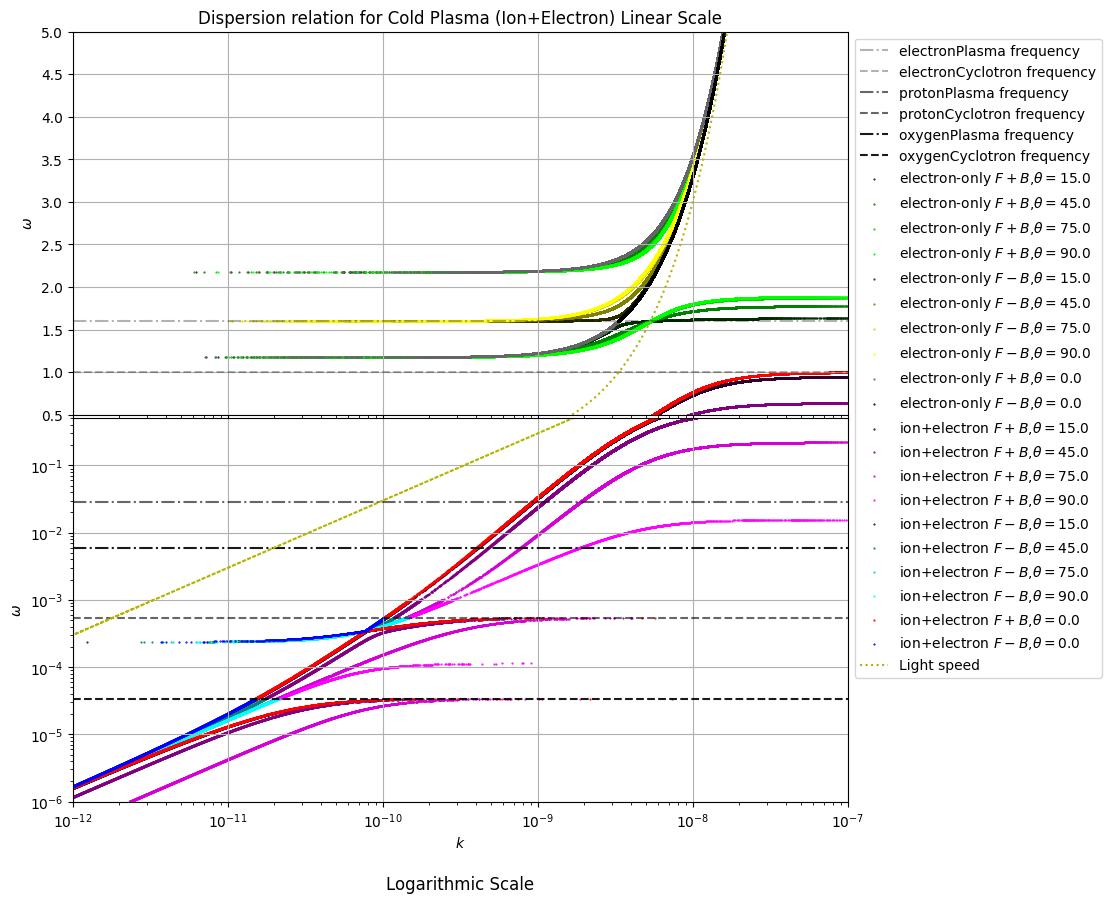

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# 並列化用ライブラリ、引数操作用ライブラリをインポート
import multiprocessing
from functools import partial

#光速
c = 3*10**8

#質量
#プラズマ周波数(電子のサイクロトロン周波数で規格化)
#サイクロトロン周波数(電子のサイクロトロン周波数で規格化)

#辞書型を用いることで、パラメーターを直感的に扱えるようにする。

me = 9.1093837015e-31  #電子
oe = 1.0      #電子
pe = oe*1.6  #電子

electrons = {"mass":me,"charge_sign":-1.0,"Cyclotron_freq":oe,"Plasma_freq":pe,"name":"electron"}


a = 0.6  #組成比

mh = 1.67262192e-27    #プロトン
oh = oe*me/mh  #プロトン
ph = pe*np.sqrt(a*me/mh)  #プロトン

protons = {"mass":mh,"charge_sign":1.0,"Cyclotron_freq":oh,"Plasma_freq":ph,"name":"proton"}


mo = mh*16     #酸素
oo = oe*me/mo  #酸素
po = pe*np.sqrt((1.0-a)*me/mo)  #酸素

oxygens = {"mass":mh,"charge_sign":1.0,"Cyclotron_freq":oo,"Plasma_freq":po,"name":"oxygen"}

elements = {"electron":electrons,"proton":protons,"oxygen":oxygens}



def filter_arrays(sorted_w, sorted_kp, scale_factor,ratio):

    # x軸方向で隣接する要素間の差を計算(logで)
    differences = np.diff(np.log10(sorted_kp))

    # 刻み幅の閾値を計算（scale_factorをそのまましきい値とする。）
    threshold = scale_factor

    # 閾値以下もしくは8の倍数インデックスを持つ要素のインデックスを取得
    valid_indices = [i for i, diff in enumerate(differences, 1) if diff > threshold or i % 4 == 0]

    # 有効な要素のみを抽出
    filtered_w = sorted_w[valid_indices]
    filtered_kp = sorted_kp[valid_indices]

    return filtered_w, filtered_kp

# 分散関係の計算を関数化
def calc_disp(theta,w,only_electron):

  R = np.ones(w.shape[0])
  L = np.ones(w.shape[0])
  P = np.ones(w.shape[0])

  #電子のみか否かをここで判定
  if only_electron:
     plasma_frequencies = elements["electron"]["Plasma_freq"]
     plasma_cycltrons = elements["electron"]["Cyclotron_freq"]
     charge_sign = elements["electron"]["charge_sign"]
     R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
     L += -plasma_frequencies**2/(w*(w-plasma_cycltrons*charge_sign))
     P += -plasma_frequencies**2/(w*w)
  else:
    for element in elements.values():
      plasma_frequencies = element["Plasma_freq"]
      plasma_cycltrons = element["Cyclotron_freq"]
      charge_sign = element["charge_sign"]
      R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
      L += -plasma_frequencies**2/(w*(w-plasma_cycltrons*charge_sign))
      P += -plasma_frequencies**2/(w*w)

  S = (R+L)/2

  A = S*np.sin(theta)**2+P*np.cos(theta)**2
  B = R*L*np.sin(theta)**2+P*S*(1+np.cos(theta)**2)
  C = P*R*L
  F = np.sqrt(B**2-4*A*C)
  n2p = (B+F)/(2*A)  #複合プラス
  n2m = (B-F)/(2*A)  #複合マイナス
  #k=の形にする
  kpp = w/c*np.sqrt(n2p)
#     kpm = -w/c*np.sqrt(n2p)
  kmp = w/c*np.sqrt(n2m)
#     kmm = -w/c*np.sqrt(n2m)


  # 密集している領域の点を省く

  # 一応負の値も削除
  # Nanを排除
  non_nan_neg_kpp_indices = np.where((~np.isnan(kpp)) & (kpp > 0))[0]
  non_nan_neg_kmp_indices = np.where((~np.isnan(kmp)) & (kmp > 0))[0]


  # NaNと負の値がない要素のみで配列をフィルタリング
  nan_filtered_kpp = kpp[non_nan_neg_kpp_indices]
  nan_filtered_pw = w[non_nan_neg_kpp_indices]

  nan_filtered_kmp = kmp[non_nan_neg_kmp_indices]
  nan_filtered_mw = w[non_nan_neg_kmp_indices]

  # 波数順になるように並び替える。
  sorted_indices = np.argsort(nan_filtered_kpp)
  sorted_pw = nan_filtered_pw[sorted_indices]
  sorted_kpp = nan_filtered_kpp[sorted_indices]

  sorted_indices = np.argsort(nan_filtered_kmp)
  sorted_mw = nan_filtered_mw[sorted_indices]
  sorted_kmp = nan_filtered_kmp[sorted_indices]

  filtered_pw, filtered_kpp = sorted_pw,sorted_kpp
  filtered_mw, filtered_kmp = sorted_mw,sorted_kmp

  for i in range(2):
    filtered_pw, filtered_kpp = filter_arrays(filtered_pw,filtered_kpp,0.0025,i)
    filtered_mw, filtered_kmp = filter_arrays(filtered_mw,filtered_kmp,0.0025,i)


  return [filtered_kpp,filtered_kmp,filtered_pw, filtered_mw, theta]


# 電子のみを実行

w = np.arange(1,5,10**-6)  #変数は周波数

thetas = [0,np.pi/12,np.pi/4,np.pi/2.4,np.pi/2]

# 並列化して処理を実行

pool = multiprocessing.Pool()
partial_func = partial(calc_disp, w=w, only_electron = True) # wは並列化しないための指示
results_electron = pool.map(partial_func, thetas)
pool.close()
pool.join()



# イオンを実行

w = np.arange(10**-6,1,10**-6)  #変数は周波数
wlog =  np.logspace(-6, -3, 10**5) # 対数の配列も生成
w = np.concatenate((w, wlog)) # 上の2つの配列を結合

thetas = [0,np.pi/12,np.pi/4,np.pi/2.4,np.pi/2]

# 並列化して処理を実行

pool = multiprocessing.Pool()
partial_func = partial(calc_disp, w=w, only_electron = False) # wは並列化しないための指示
results_ion = pool.map(partial_func, thetas)
pool.close()
pool.join()





# 2つのグラフを描画

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

ax1.set_xscale('log')
ax1.set_title('Dispersion relation for Cold Plasma (Ion+Electron) Linear Scale')
ax1.grid(True)
ax1.set_ylim(0.5,5.0)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Logarithmic Scale', y = -0.25)
ax2.grid(True)
ax2.set_ylim(10**-6.0,0.5)

# 描画

# 描画関数


def plot_disp(results, w, colors, ax, source):

    for i in [1,0]: # kpp & kmp
      # 配列結合は効果なさそうだったのでやめた。
      for result in results: # 各thetaごとに
        theta = result[4]
        color = colors[i]
        colorpower = (theta/(np.pi/2))
        if(theta != 0):
           if(color == 'cyan'):
              color = (0,colorpower,colorpower)
           if(color == 'magenta'):
              color = (colorpower,0,colorpower)
           if(color == 'yellow'):
              color = (colorpower,colorpower,0)
           if(color == 'green'):
              color = (0,colorpower,0)
        if(i == 0):
          ax.scatter(result[i], result[i+2], color=color, s= 0.3, label=source + " " + r'$F-B$,$\theta=$'+str(theta/np.pi*180))
        else:
          ax.scatter(result[i], result[i+2], color=color, s= 0.3, label=source + " " + r'$F+B$,$\theta=$'+str(theta/np.pi*180))

count = 0
for element in elements.values():
  plasma_frequencies = element["Plasma_freq"]
  plasma_cycltrons = element["Cyclotron_freq"]
  count += 1
  ax1.axhline(y=plasma_frequencies,linestyle='dashdot',alpha=0.3*count,color='k',label=element['name']+'Plasma frequency')
  ax1.axhline(y=plasma_cycltrons,linestyle='dashed',alpha=0.3*count,color='k',label=element['name']+'Cyclotron frequency')
  ax2.axhline(y=plasma_frequencies,linestyle='dashdot',alpha=0.3*count,color='k',label=element['name']+'Plasma frequency')
  ax2.axhline(y=plasma_cycltrons,linestyle='dashed',alpha=0.3*count,color='k',label=element['name']+'Cyclotron frequency')

color_map = {'theta_0': ('black', '0.4'), 'theta_not_0': ('yellow', 'green')}

# 内包リストを使って、result[4]←theta が0のリストとそれを省いたリストを生成。
plot_disp([result for result in results_electron if result[4] != 0], w, color_map['theta_not_0'], ax1, 'electron-only')
plot_disp([result for result in results_electron if result[4] == 0], w, color_map['theta_0'], ax1, 'electron-only')
plot_disp([result for result in results_electron if result[4] != 0], w, color_map['theta_not_0'], ax2, 'electron-only')
plot_disp([result for result in results_electron if result[4] == 0], w, color_map['theta_0'], ax2, 'electron-only')

color_map = {'theta_0': ('blue', 'red'), 'theta_not_0': ('cyan', 'magenta')}

# 内包リストを使って、result[4]←theta が0のリストとそれを省いたリストを生成。
plot_disp([result for result in results_ion if result[4] != 0], w, color_map['theta_not_0'], ax1, 'ion+electron')
plot_disp([result for result in results_ion if result[4] == 0], w, color_map['theta_0'], ax1, 'ion+electron')
plot_disp([result for result in results_ion if result[4] != 0], w, color_map['theta_not_0'], ax2, 'ion+electron')
plot_disp([result for result in results_ion if result[4] == 0], w, color_map['theta_0'], ax2, 'ion+electron')


plt.xlim(10**-12,10**-7)


lightcol = (0.7,0.7,0.0)
w1 = np.arange(0.0,5,10**-6)
ax1.plot(w1/c,w1,linestyle='dotted',alpha=1.0,color=lightcol,label='Light speed')
ax2.plot(w/c,w,linestyle='dotted',alpha=1.0,color=lightcol,label='Light speed')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
#ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.set_xlabel(r'$k$')
ax1.set_ylabel(r'$\omega$')
ax2.set_ylabel(r'$\omega$')
fig.subplots_adjust(hspace=0.01)
